In [1]:
import sys
sys.path.append('../')
from matplotlib import rcParams
rcParams['font.family'] = 'SimHei'
%matplotlib inline
import backtrader as bt

In [2]:
from datafeed.dataloader import CSVDataloader
df = CSVDataloader.get_backtrader_df('000300.SH',start_date='20050101')
df.dropna()

,open,high,low,close,volume,openinterest
date,,,,,,
2005-01-04,994.7690,994.7690,980.6580,982.7940,7.412869e+06,0
2005-01-05,981.5770,997.3230,979.8770,992.5640,7.119109e+06,0
2005-01-06,993.3310,993.7880,980.3300,983.1740,6.288029e+06,0
2005-01-07,983.0450,995.7110,979.8120,983.9580,7.298694e+06,0
2005-01-10,983.7600,993.9590,979.7890,993.8790,5.791698e+06,0
...,...,...,...,...,...,...
2024-06-12,3539.0947,3551.1706,3531.5657,3544.1225,1.228137e+08,0
2024-06-13,3548.2162,3551.0771,3520.1802,3526.1306,1.232455e+08,0
2024-06-14,3514.7998,3547.1473,3503.5233,3541.5331,1.715169e+08,0


In [3]:
class TurtleStrategy(bt.Strategy):
#默认参数
    params = (('long_period',25),
              ('short_period',15),  
              ('printlog', False), )   

    def __init__(self):        
        self.order = None      
        self.buyprice = 0      
        self.buycomm = 0      
        self.buy_size = 0      
        self.buy_count = 0       
        # 海龟交易法则中的唐奇安通道和平均波幅ATR        
        self.H_line = bt.indicators.Highest(self.data.high(-1), period=self.p.long_period)        
        self.L_line = bt.indicators.Lowest(self.data.low(-1), period=self.p.short_period)       
        self.TR = bt.indicators.Max((self.data.high(0)- self.data.low(0)),\
                                    abs(self.data.close(-1)-self.data.high(0)), \
                                    abs(self.data.close(-1)  - self.data.low(0)))        
        self.ATR = bt.indicators.SimpleMovingAverage(self.TR, period=14)       
        # 价格与上下轨线的交叉      
        self.buy_signal = bt.ind.CrossOver(self.data.close(0), self.H_line)        
        self.sell_signal = bt.ind.CrossOver(self.data.close(0), self.L_line)    

    def next(self): 
        if self.order:
            return        
        #入场：价格突破上轨线且空仓时        
        if self.buy_signal > 0 and self.buy_count == 0: 
            
            self.buy_size = self.broker.getvalue() * 0.01 / self.ATR            
            self.buy_size  = int(self.buy_size  / 100) * 100                             
            self.sizer.p.stake = self.buy_size             
            self.buy_count = 1     
            print('空仓时买入',self.buy_size)
            self.order = self.buy()        
        #加仓：价格上涨了买入价的0.5的ATR且加仓次数少于3次（含）        
        elif self.data.close >self.buyprice+0.5*self.ATR[0] and self.buy_count > 0 and self.buy_count <=4:   
            print('加仓买入')
            self.buy_size  = self.broker.getvalue() * 0.01 / self.ATR            
            self.buy_size  = int(self.buy_size  / 100) * 100            
            self.sizer.p.stake = self.buy_size             
            self.order = self.buy()           
            self.buy_count += 1        
        #离场：价格跌破下轨线且持仓时        
        elif self.sell_signal < 0 and self.buy_count > 0:       
            print('平仓信号卖出')
            self.order = self.sell()            
            self.buy_count = 0        
        #止损：价格跌破买入价的2个ATR且持仓时        
        elif self.data.close < (self.buyprice - 2*self.ATR[0]) and self.buy_count > 0:      
            print('止损信号卖出')
            self.order = self.sell()
            self.buy_count = 0   

    #交易记录日志（默认不打印结果）
    def log(self, txt, dt=None,doprint=False):
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print(f'{dt.isoformat()},{txt}')

    #记录交易执行情况（默认不输出结果）
    def notify_order(self, order):
        # 如果order为submitted/accepted,返回空
        if order.status in [order.Submitted, order.Accepted]:
            return
        # 如果order为buy/sell executed,报告价格结果
        if order.status in [order.Completed]: 
            if order.isbuy():
                self.log(f'买入:\n价格:{order.executed.price},\
                成本:{order.executed.value},\
                手续费:{order.executed.comm}')

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:
                self.log(f'卖出:\n价格：{order.executed.price},\
                成本: {order.executed.value},\
                手续费{order.executed.comm}')

            self.bar_executed = len(self) 

        # 如果指令取消/交易失败, 报告结果
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('交易失败')
        self.order = None

    #记录交易收益情况（可省略，默认不输出结果）
    def notify_trade(self,trade):
        if not trade.isclosed:
            return
        self.log(f'策略收益：\n毛收益 {trade.pnl:.2f}, 净收益 {trade.pnlcomm:.2f}')

    def stop(self):
        self.log(f'(组合线：{self.p.long_period},{self.p.short_period})； \
        期末总资金: {self.broker.getvalue():.2f}', doprint=True)

In [4]:
class TradeSizer(bt.Sizer):
    params = (('stake', 1),)
    def _getsizing(self, comminfo, cash, data, isbuy):
        if isbuy:
            return self.p.stake
        position = self.broker.getposition(data)
        if not position.size:
            return 0
        else:
            return position.size
        return self.p.stake
        
cerebro = bt.Cerebro()
cerebro.broker.setcash(100*10000.0)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

data = bt.feeds.PandasData(dataname=df)
cerebro.adddata(data)
cerebro.addsizer(TradeSizer) 

print('初始资金: %.2f' % cerebro.broker.getvalue())
cerebro.addstrategy(TurtleStrategy)
strats = cerebro.run()

print('期末资金: %.2f' % cerebro.broker.getvalue())

初始资金: 1000000.00
空仓时买入 500
平仓信号卖出
空仓时买入 700
加仓买入
加仓买入
加仓买入
加仓买入
平仓信号卖出
空仓时买入 900
加仓买入
加仓买入
加仓买入
加仓买入
平仓信号卖出
空仓时买入 1000
加仓买入
加仓买入
加仓买入
加仓买入
平仓信号卖出
空仓时买入 700
加仓买入
加仓买入
加仓买入
加仓买入
平仓信号卖出
空仓时买入 100
止损信号卖出
空仓时买入 200
加仓买入
加仓买入
加仓买入
加仓买入
平仓信号卖出
空仓时买入 200
加仓买入
加仓买入
加仓买入
加仓买入
平仓信号卖出
空仓时买入 100
止损信号卖出
空仓时买入 300
止损信号卖出
空仓时买入 600
加仓买入
加仓买入
加仓买入
加仓买入
平仓信号卖出
空仓时买入 400
加仓买入
加仓买入
加仓买入
加仓买入
平仓信号卖出
空仓时买入 400
加仓买入
加仓买入
加仓买入
加仓买入
平仓信号卖出
空仓时买入 700
加仓买入
加仓买入
加仓买入
加仓买入
平仓信号卖出
空仓时买入 600
加仓买入
加仓买入
加仓买入
加仓买入
平仓信号卖出
空仓时买入 600
加仓买入
加仓买入
加仓买入
加仓买入
平仓信号卖出
空仓时买入 800
平仓信号卖出
空仓时买入 600
加仓买入
加仓买入
加仓买入
加仓买入
平仓信号卖出
空仓时买入 1000
加仓买入
加仓买入
加仓买入
止损信号卖出
空仓时买入 900
加仓买入
加仓买入
加仓买入
加仓买入
平仓信号卖出
空仓时买入 1000
加仓买入
加仓买入
加仓买入
加仓买入
止损信号卖出
空仓时买入 900
加仓买入
加仓买入
加仓买入
加仓买入
平仓信号卖出
空仓时买入 1000
加仓买入
加仓买入
平仓信号卖出
空仓时买入 1300
止损信号卖出
空仓时买入 1000
加仓买入
加仓买入
加仓买入
止损信号卖出
空仓时买入 1600
止损信号卖出
空仓时买入 1800
加仓买入
加仓买入
加仓买入
加仓买入
平仓信号卖出
空仓时买入 1500
加仓买入
加仓买入
加仓买入
加仓买入
平仓信号卖出
空仓时买入 1100
加仓买入
加仓买入
加仓买入
加仓买入
平仓信号卖出
空仓时买入 700
加仓买入
加仓买入
加仓买入
加仓买入
平仓信号卖出
空仓时买入 500
加仓买入
加仓买入
加仓买

In [5]:
strat0 = strats[0]
pyfolio = strat0.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfolio.get_pf_items()
import empyrical as em
em.annual_return(returns)

0.11378507813271344

In [6]:
import quantstats as qs
qs.reports.metrics(returns)

                    Strategy
------------------  ----------
Start Period        2005-01-04
End Period          2024-06-18
Risk-Free Rate      0.0%
Time in Market      40.0%

Cumulative Return   654.27%
CAGR﹪              7.43%

Sharpe              0.99
Prob. Sharpe Ratio  100.0%
Sortino             1.42
Sortino/√2          1.0
Omega               1.34

Max Drawdown        -19.25%
Longest DD Days     1486

Gain/Pain Ratio     0.34
Gain/Pain (1M)      1.65

Payoff Ratio        1.02
Profit Factor       1.34
Common Sense Ratio  1.84
CPC Index           0.78
Tail Ratio          1.37
Outlier Win Ratio   11.3
Outlier Loss Ratio  3.21

MTD                 0.0%
3M                  -2.1%
6M                  1.79%
YTD                 1.79%
1Y                  -1.98%
3Y (ann.)           0.67%
5Y (ann.)           1.19%
10Y (ann.)          4.7%
All-time (ann.)     7.43%

Avg. Drawdown       -3.07%
Avg. Drawdown Days  76
Recovery Factor     11.16
Ulcer Index         0.08
Serenity Index      1.52


                    Strategy
------------------  ----------
Start Period        2005-01-04
End Period          2024-06-18
Risk-Free Rate      0.0%
Time in Market      40.0%

Cumulative Return   654.27%
CAGR﹪              7.43%

Sharpe              0.99
Prob. Sharpe Ratio  100.0%
Sortino             1.42
Sortino/√2          1.0
Omega               1.34

Max Drawdown        -19.25%
Longest DD Days     1486

Gain/Pain Ratio     0.34
Gain/Pain (1M)      1.65

Payoff Ratio        1.02
Profit Factor       1.34
Common Sense Ratio  1.84
CPC Index           0.78
Tail Ratio          1.37
Outlier Win Ratio   11.3
Outlier Loss Ratio  3.21

MTD                 0.0%
3M                  -2.1%
6M                  1.79%
YTD                 1.79%
1Y                  -1.98%
3Y (ann.)           0.67%
5Y (ann.)           1.19%
10Y (ann.)          4.7%
All-time (ann.)     7.43%

Avg. Drawdown       -3.07%
Avg. Drawdown Days  76
Recovery Factor     11.16
Ulcer Index         0.08
Serenity Index      1.52


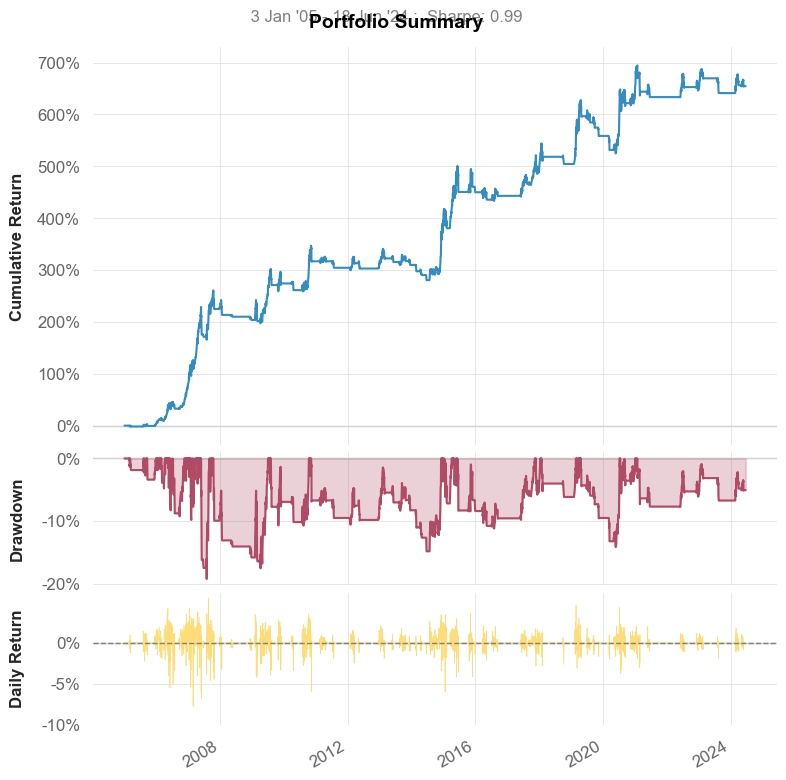

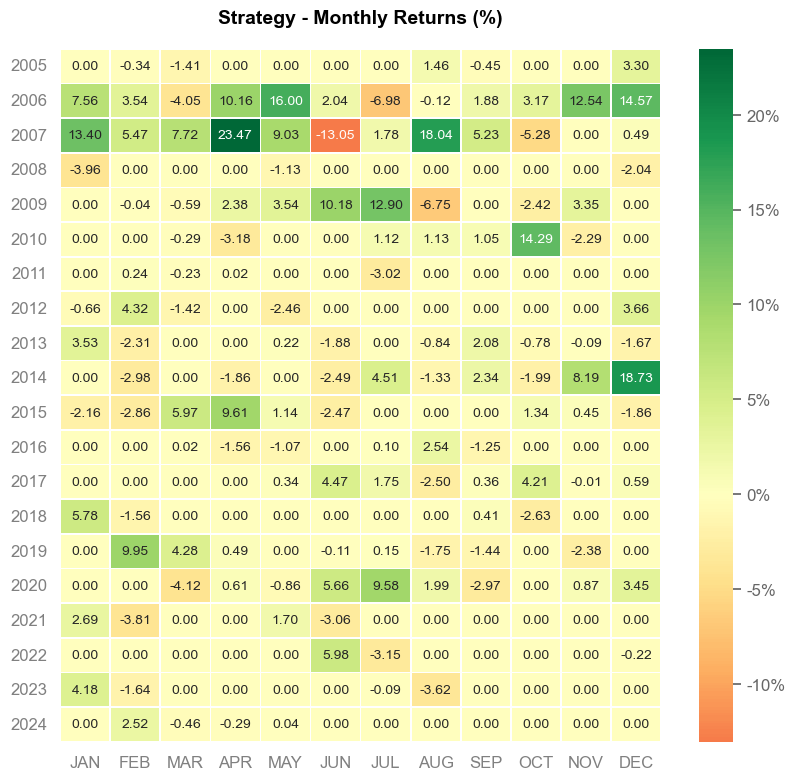

In [7]:
qs.reports.basic(returns)